# COPOM Meetings - Scraping, plotting, analysis

### Marcos Costa Santos Carreira - Jun 2017

## Importing Packages and setup

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import bs4

import re

import docx

## Get COPOM page (in English)

In [3]:
page = requests.get('http://www.bcb.gov.br/?INTEREST')
soup = bs4.BeautifulSoup(page.text, "lxml")
tabela = soup.find('table')

## Auxiliary functions

In [4]:
def mstrip(s):
    if (s == None or s.strip() == u''):
        return np.nan
    else:
        return s.strip()

In [5]:
def rton(row):
    return [int(row[0]), pd.to_datetime(row[1]), row[2], row[3],
            float(row[4]), float(row[5]), float(row[6]), float(row[7])]

## Create table

After tinkering and searching for help to extract information from the poor choice of format on the table:

In [6]:
COPOMt = []
#tabela.findAll("th") - This was useful but i forgot why
#The first 3 rows are the header - let's get the data only
#We will add the header later
for row in tabela.findAll("tr")[3:]:
    cells = row.findAll("td")
    arow = row.findAll("td")[0].a.contents
    if arow==[]:
        arow=np.nan
    else:
        arow=arow[0]
    trow = [mstrip(cell.find(text=True)) for cell in cells]
    trow.insert(1, arow)
    trow[2] = pd.to_datetime(trow[2])
    dtl = trow[4].partition(" - ")
    trow[4] = pd.to_datetime(dtl[0])
    trow.insert(5, pd.to_datetime(dtl[2]))
    trow[6] = float(trow[6])
    trow[7] = float(trow[7])
    trow[8] = float(trow[8])
    trow[9] = float(trow[9])
    COPOMt = COPOMt + [trow]

COPOMt is now a list of lists; we will create a Data Frame with the appropriate column names

In [7]:
coldfC = ['Meeting', 'Ex', 'Date', 'Bias', 'Start', 'End',
          'SETA', 'TBAN', 'SELICef', 'SELICpy']
dfCOPOM = pd.DataFrame(COPOMt, columns=coldfC)

In [8]:
dfCOPOM.head()

,Meeting,Ex,Date,Bias,Start,End,SETA,TBAN,SELICef,SELICpy
0,207,NaN,2017-05-31,NaN,2017-06-01,NaT,10.25,NaN,NaN,NaN
1,206,NaN,2017-04-12,NaN,2017-04-13,2017-05-31,11.25,NaN,NaN,NaN
2,205,NaN,2017-02-22,NaN,2017-02-23,2017-04-12,12.25,NaN,1.51,12.15
3,204,NaN,2017-01-11,NaN,2017-01-12,2017-02-22,13.00,NaN,1.45,12.90
4,203,NaN,2016-11-30,NaN,2016-12-01,2017-01-11,13.75,NaN,1.53,13.65


## Extraordinary meetings

In [9]:
dfCOPOM[dfCOPOM['Ex'].notnull()]

,Meeting,Ex,Date,Bias,Start,End,SETA,TBAN,SELICef,SELICpy
131,76,ex.,2002-10-14,NaN,2002-10-15,2002-10-23,21.00,NaN,0.53,20.90
187,28,ex.,1998-09-10,NaN,1998-09-11,1998-10-07,19.00,49.75,2.58,40.18
197,18,ex.,1997-10-30,NaN,1997-10-31,1997-11-30,3.05,3.23,3.18,45.67


## SELIC Target

The SELIC Target as we know today started in 1999-03-04, so we will crop the Data Frame

In [10]:
dfCOPOM[dfCOPOM['Date']=='1999-03-04']

,Meeting,Ex,Date,Bias,Start,End,SETA,TBAN,SELICef,SELICpy
182,NaN,NaN,1999-03-04,d.b.,1999-03-05,1999-03-24,45.0,NaN,2.08,44.95


In [11]:
coldfC2=['Meeting','Ex','Date','Bias','Start','End','SETA']

In [12]:
cut=dfCOPOM[dfCOPOM['Date']=='1999-03-04'].index[0]

In [13]:
dfCOPOM2=(dfCOPOM.loc[:cut])[coldfC2]

## Rows missing meeting id

In [14]:
dfCOPOM2[dfCOPOM2['Meeting'].isnull()]

,Meeting,Ex,Date,Bias,Start,End,SETA
160,NaN,NaN,2000-06-20,d.b.,2000-06-21,2000-07-07,17.5
164,NaN,NaN,2000-03-22,d.b.,2000-03-23,2000-03-28,19.0
175,NaN,NaN,1999-05-19,d.b.,1999-05-20,1999-06-08,23.5
177,NaN,NaN,NaT,used/d.b.,1999-05-10,1999-05-12,29.5
178,NaN,NaN,NaT,used/d.b.,1999-04-29,1999-05-07,32.0
179,NaN,NaN,1999-04-14,d.b.,1999-04-15,1999-04-28,34.0
181,NaN,NaN,NaT,used/d.b.,1999-03-25,1999-04-05,42.0
182,NaN,NaN,1999-03-04,d.b.,1999-03-05,1999-03-24,45.0


What is happening? Poor choice of formats - again

In [15]:
dfCOPOM.loc[158:182]

,Meeting,Ex,Date,Bias,Start,End,SETA,TBAN,SELICef,SELICpy
158,49,NaN,2000-07-19,NaN,2000-07-20,2000-08-23,16.5,NaN,1.53,16.51
159,48,NaN,NaT,used/d.b.,2000-07-10,2000-07-19,17.0,NaN,0.50,16.96
160,NaN,NaN,2000-06-20,d.b.,2000-06-21,2000-07-07,17.5,NaN,0.76,17.34
161,47,NaN,2000-05-24,NaN,2000-05-25,2000-06-20,18.5,NaN,1.28,18.39
162,46,NaN,2000-04-19,NaN,2000-04-20,2000-05-24,18.5,NaN,1.57,18.55
163,45,NaN,NaT,used/d.b.,2000-03-29,2000-04-19,18.5,NaN,1.09,18.60
164,NaN,NaN,2000-03-22,d.b.,2000-03-23,2000-03-28,19.0,NaN,0.28,18.94
165,44,NaN,2000-02-16,NaN,2000-02-17,2000-03-22,19.0,NaN,1.59,18.88
166,43,NaN,2000-01-19,NaN,2000-01-20,2000-02-16,19.0,NaN,1.45,18.87
167,42,NaN,1999-12-15,NaN,1999-12-16,2000-01-19,19.0,NaN,1.74,19.00


The 33rd meeting was on 1999-03-04, and subsequently (before the 34th meeting) the downward bias was used twice.

So we fill 'Meeting' down (we have not ordered the table yet)

In [16]:
dfCOPOM2['Meeting'] = dfCOPOM2['Meeting'].fillna(method='pad')

In [17]:
dfCOPOM2.loc[156:]

,Meeting,Ex,Date,Bias,Start,End,SETA
156,51,NaN,2000-09-20,NaN,2000-09-21,2000-10-18,16.5
157,50,NaN,2000-08-23,NaN,2000-08-24,2000-09-20,16.5
158,49,NaN,2000-07-19,NaN,2000-07-20,2000-08-23,16.5
159,48,NaN,NaT,used/d.b.,2000-07-10,2000-07-19,17.0
160,48,NaN,2000-06-20,d.b.,2000-06-21,2000-07-07,17.5
161,47,NaN,2000-05-24,NaN,2000-05-25,2000-06-20,18.5
162,46,NaN,2000-04-19,NaN,2000-04-20,2000-05-24,18.5
163,45,NaN,NaT,used/d.b.,2000-03-29,2000-04-19,18.5
164,45,NaN,2000-03-22,d.b.,2000-03-23,2000-03-28,19.0
165,44,NaN,2000-02-16,NaN,2000-02-17,2000-03-22,19.0


## Rows missing date

In [18]:
dfCOPOM2[dfCOPOM2['Date'].isnull()]

,Meeting,Ex,Date,Bias,Start,End,SETA
159,48,NaN,NaT,used/d.b.,2000-07-10,2000-07-19,17.0
163,45,NaN,NaT,used/d.b.,2000-03-29,2000-04-19,18.5
174,35,NaN,NaT,used/d.b.,1999-06-09,1999-06-23,22.0
176,34,NaN,NaT,used/d.b.,1999-05-13,1999-05-19,27.0
177,34,NaN,NaT,used/d.b.,1999-05-10,1999-05-12,29.5
178,34,NaN,NaT,used/d.b.,1999-04-29,1999-05-07,32.0
180,33,NaN,NaT,used/d.b.,1999-04-06,1999-04-14,39.5
181,33,NaN,NaT,used/d.b.,1999-03-25,1999-04-05,42.0


In [19]:
dfCOPOM2['Bias'].unique()

array([nan, 'u.b.', 'd.b.', 'used/d.b.'], dtype=object)

In [20]:
dfCOPOM2[dfCOPOM2['Bias']=='used/d.b.']

,Meeting,Ex,Date,Bias,Start,End,SETA
159,48,NaN,NaT,used/d.b.,2000-07-10,2000-07-19,17.0
163,45,NaN,NaT,used/d.b.,2000-03-29,2000-04-19,18.5
174,35,NaN,NaT,used/d.b.,1999-06-09,1999-06-23,22.0
176,34,NaN,NaT,used/d.b.,1999-05-13,1999-05-19,27.0
177,34,NaN,NaT,used/d.b.,1999-05-10,1999-05-12,29.5
178,34,NaN,NaT,used/d.b.,1999-04-29,1999-05-07,32.0
180,33,NaN,NaT,used/d.b.,1999-04-06,1999-04-14,39.5
181,33,NaN,NaT,used/d.b.,1999-03-25,1999-04-05,42.0


They all are uses of the bias. Let's use the 'Start' column to fill the dates for the uses of the bias.

In [21]:
dfCOPOM2['Date'] = dfCOPOM2['Date'].fillna(dfCOPOM2['Start'])

## Reordering

In [22]:
dfCOPOM2.sort_values('Date',inplace=True)

In [23]:
dfCOPOM2.set_index('Date',inplace=True)

In [24]:
dfCOPOM2.head()

,Meeting,Ex,Bias,Start,End,SETA
Date,,,,,,
1999-03-04,33,NaN,d.b.,1999-03-05,1999-03-24,45.0
1999-03-25,33,NaN,used/d.b.,1999-03-25,1999-04-05,42.0
1999-04-06,33,NaN,used/d.b.,1999-04-06,1999-04-14,39.5
1999-04-14,34,NaN,d.b.,1999-04-15,1999-04-28,34.0
1999-04-29,34,NaN,used/d.b.,1999-04-29,1999-05-07,32.0


In [25]:
dfCOPOM2.tail()

,Meeting,Ex,Bias,Start,End,SETA
Date,,,,,,
2016-11-30,203,NaN,NaN,2016-12-01,2017-01-11,13.75
2017-01-11,204,NaN,NaN,2017-01-12,2017-02-22,13.00
2017-02-22,205,NaN,NaN,2017-02-23,2017-04-12,12.25
2017-04-12,206,NaN,NaN,2017-04-13,2017-05-31,11.25
2017-05-31,207,NaN,NaN,2017-06-01,NaT,10.25


## Exploring

Plotting the SELIC Target:

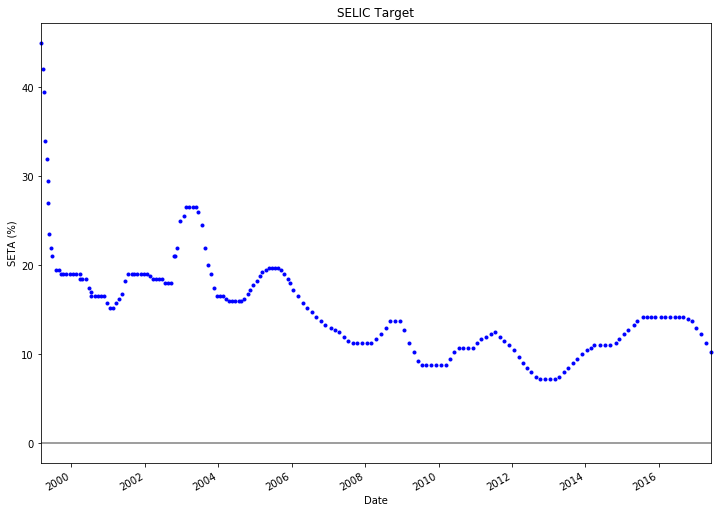

In [26]:
dfCOPOM2['SETA'].plot(figsize=(12,9),marker='.',linestyle='None',
    color='blue',clip_on=False,title='SELIC Target');
plt.ylabel('SETA (%)');
plt.axhline(0,color='gray');

And also plot the changes in the SELIC Target:

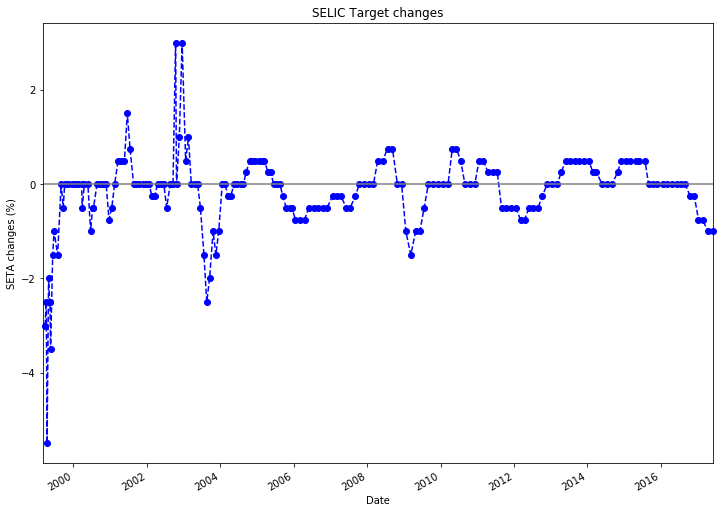

In [27]:
(dfCOPOM2['SETA'].diff()).plot(figsize=(12,9),marker='o',linestyle='--',
    color='blue',clip_on=False,title='SELIC Target changes');
plt.ylabel('SETA changes (%)');
plt.axhline(0,color='gray');

We observe that almost always sign changes "stop" at zero - except in 2011 (31-Aug).

Plotting the changes of the changes:

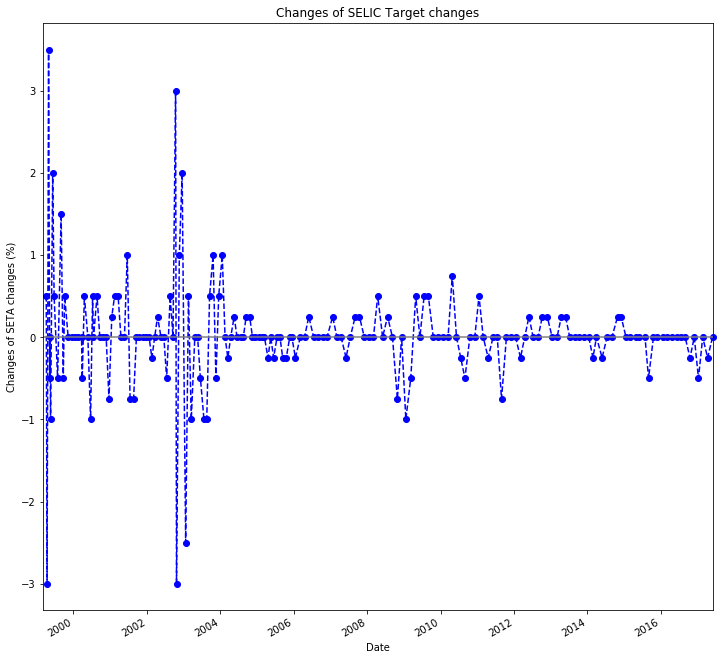

In [28]:
((dfCOPOM2['SETA'].diff()).diff()).plot(figsize=(12,12),marker='o',
    linestyle='--',color='blue',clip_on=False,
    title='Changes of SELIC Target changes');
plt.ylabel('Changes of SETA changes (%)');
plt.axhline(0,color='gray');

From 2004 onward:

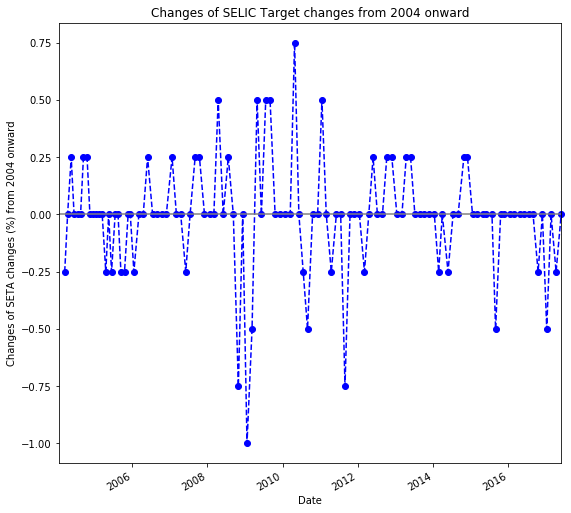

In [29]:
((dfCOPOM2['SETA'].loc['2004':].diff()).diff()).plot(figsize=(9,9),marker='o',
    linestyle='--',color='blue',clip_on=False,
    title='Changes of SELIC Target changes from 2004 onward');
plt.ylabel('Changes of SETA changes (%) from 2004 onward');
plt.axhline(0,color='gray');

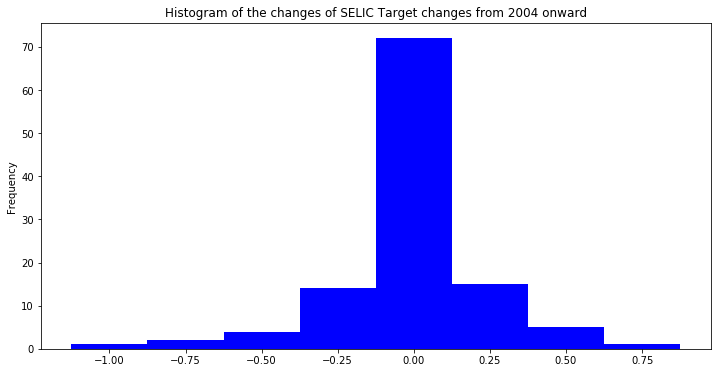

In [30]:
d2b=np.arange(-1.125,1.125,0.25)
((dfCOPOM2['SETA'].loc['2004':].diff()).diff()).plot(figsize=(12,6),
    kind='hist',bins=d2b,color='blue',
    title='Histogram of the changes of SELIC Target changes from 2004 onward');

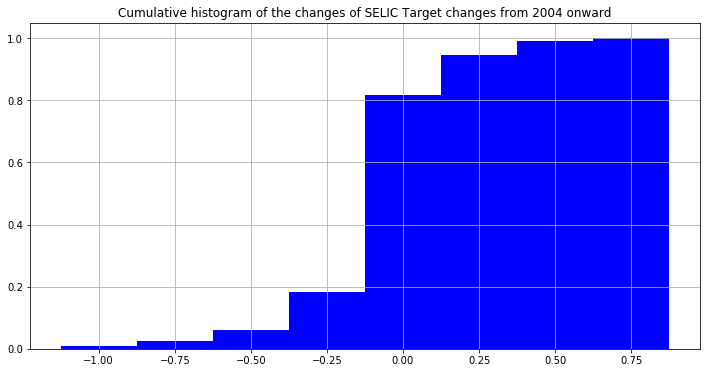

In [345]:
((dfCOPOM2['SETA'].loc['2004':].diff()).diff()).hist(figsize=(12,6),bins=d2b,
    normed=True,cumulative=True,color='blue');
plt.title('Cumulative histogram of the changes of SELIC Target changes from 2004 onward');

So most of the time (in more than 60% of the meetings) there's no change in the rhythm of the changes.

In [32]:
x=dfCOPOM2['SETA'].diff().values
y=dfCOPOM2['SETA'].diff().shift().values
dfxy=pd.DataFrame({'Changes':x,'Next Changes':y})

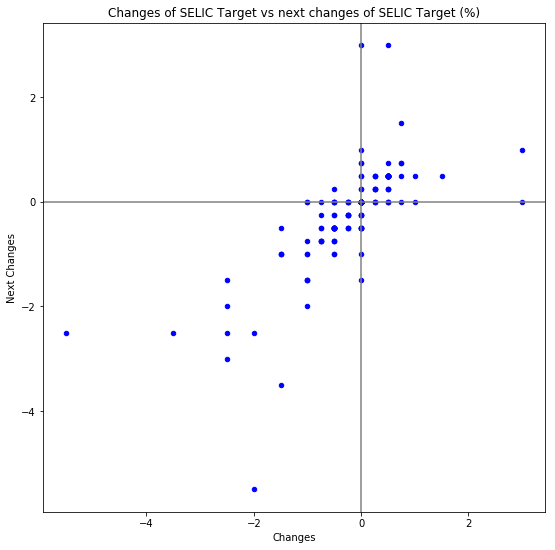

In [33]:
dfxy.plot.scatter('Changes','Next Changes',figsize=(9,9),color='blue');
plt.title('Changes of SELIC Target vs next changes of SELIC Target (%)');
plt.axhline(0,color='gray');
plt.axvline(0,color='gray');

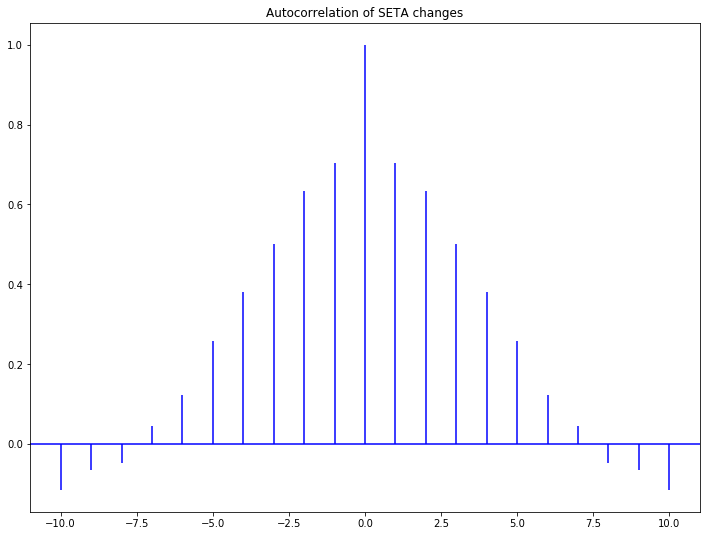

In [356]:
plt.figure(figsize=(12,9));
plt.title('Autocorrelation of SETA changes')
plt.acorr(dfCOPOM2['SETA'].diff().dropna(),color='blue');

## Plots by BCB president

In [34]:
fraga=pd.date_range('1999-03-04','2002-12-31')
meirelles=pd.date_range('2003-01-01','2010-12-31')
tombini=pd.date_range('2011-01-01','2016-08-06')
goldfajn=pd.date_range('2016-08-07','2017-12-31')

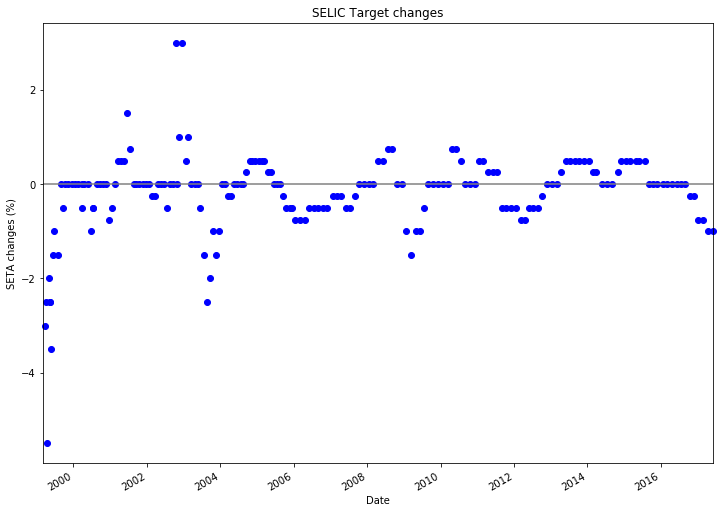

In [35]:
(dfCOPOM2['SETA'].diff()).plot(figsize=(12,9),marker='o',linestyle='None',
    color='blue',clip_on=False,
    title='SELIC Target changes');
plt.ylabel('SETA changes (%)');
plt.axhline(0,color='gray');

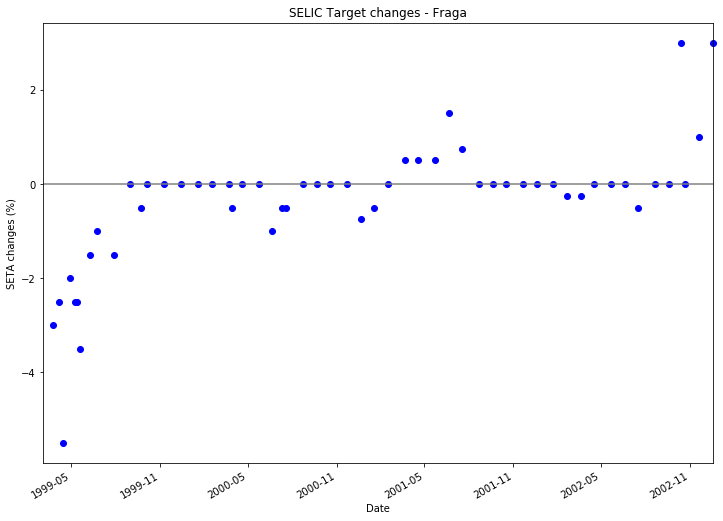

In [36]:
(dfCOPOM2['SETA'].diff()[dfCOPOM2.index.isin(fraga)]).plot(figsize=(12,9),
    marker='o',linestyle='None',color='blue',clip_on=False,
    title='SELIC Target changes - Fraga');
plt.ylabel('SETA changes (%)');
plt.axhline(0,color='gray');

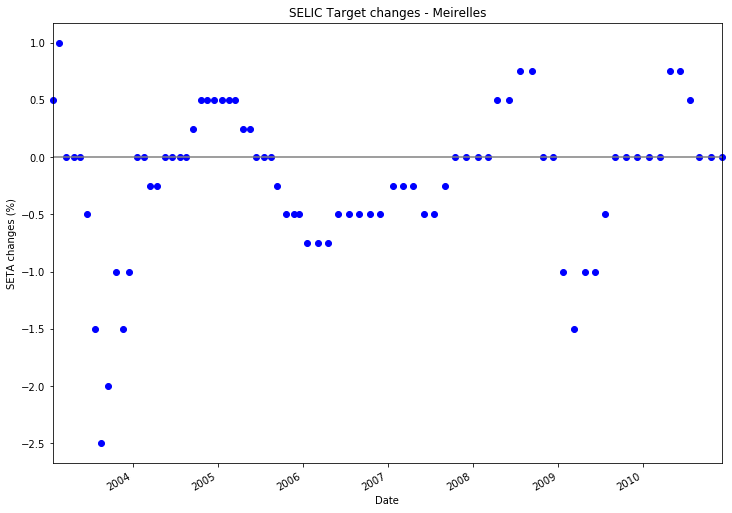

In [37]:
(dfCOPOM2['SETA'].diff()[dfCOPOM2.index.isin(meirelles)]).plot(figsize=(12,9),
    marker='o',linestyle='None',color='blue',clip_on=False,
    title='SELIC Target changes - Meirelles');
plt.ylabel('SETA changes (%)');
plt.axhline(0,color='gray');

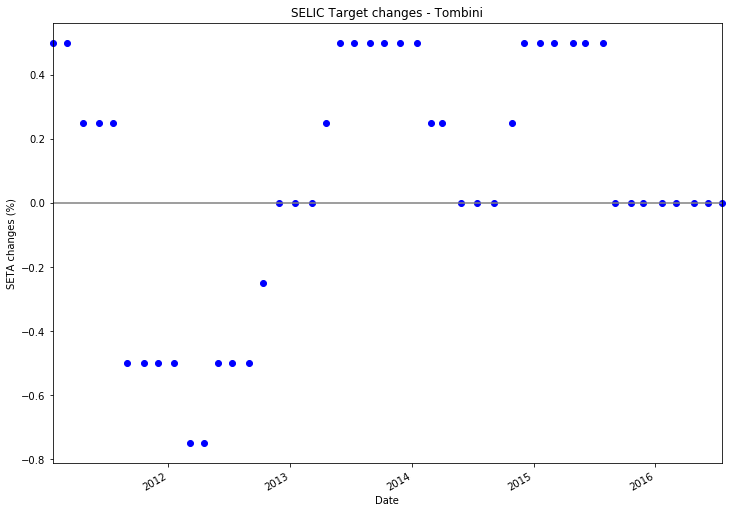

In [38]:
(dfCOPOM2['SETA'].diff()[dfCOPOM2.index.isin(tombini)]).plot(figsize=(12,9),
    marker='o',linestyle='None',color='blue',clip_on=False,
    title='SELIC Target changes - Tombini');
plt.ylabel('SETA changes (%)');
plt.axhline(0,color='gray');

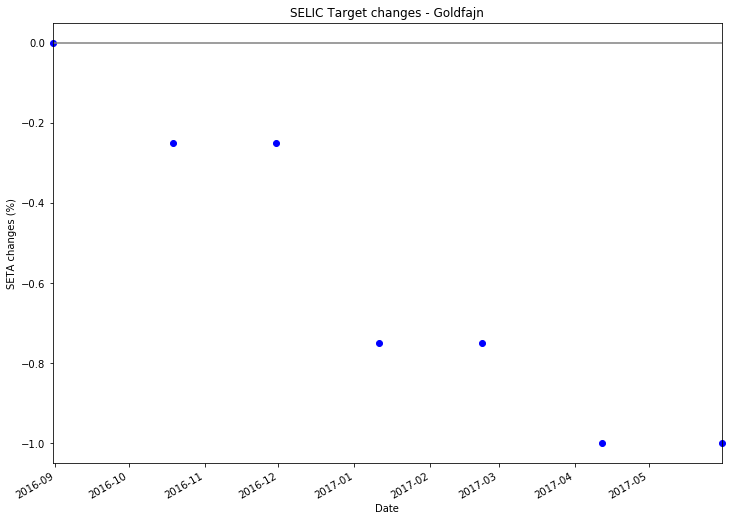

In [39]:
(dfCOPOM2['SETA'].diff()[dfCOPOM2.index.isin(goldfajn)]).plot(figsize=(12,9),
    marker='o',linestyle='None',color='blue',clip_on=False,
    title='SELIC Target changes - Goldfajn');
plt.ylabel('SETA changes (%)');
plt.axhline(0,color='gray');

## COPOM statements

In [40]:
dfCOPOM.head()

,Meeting,Ex,Date,Bias,Start,End,SETA,TBAN,SELICef,SELICpy
0,207,NaN,2017-05-31,NaN,2017-06-01,NaT,10.25,NaN,NaN,NaN
1,206,NaN,2017-04-12,NaN,2017-04-13,2017-05-31,11.25,NaN,NaN,NaN
2,205,NaN,2017-02-22,NaN,2017-02-23,2017-04-12,12.25,NaN,1.51,12.15
3,204,NaN,2017-01-11,NaN,2017-01-12,2017-02-22,13.00,NaN,1.45,12.90
4,203,NaN,2016-11-30,NaN,2016-12-01,2017-01-11,13.75,NaN,1.53,13.65


In [114]:
lstmeet=int(dfCOPOM['Meeting'][0])
lstmeet

207

In [82]:
def clrn(x):
    if type(x)==str:
        return re.sub('\r\n','',x)
    else:
        return x

In [84]:
def decistext(n):
    urld = 'http://www.bcb.gov.br/?NOTACOPOM' + str(n).zfill(3)
    paged = requests.get(urld)
    soupd = bs4.BeautifulSoup(paged.text,"lxml")
    tagd = soupd.findAll('p')
    textd = [clrn(bstag.text) for bstag in tagd]
    return textd

In [162]:
def decistext2(urld):
    paged = open(urld).read
    soupd = bs4.BeautifulSoup(paged,'html')
    tagd = soupd.findAll('p')
    textd = [clrn(bstag.text) for bstag in tagd]
    return textd

In [42]:
meetlist2003 = np.arange(80, 202)

In [115]:
meetlist2003all = np.arange(80, lstmeet+1)

In [123]:
textdecis = []
for n in meetlist2003:
    textdecis = textdecis + [decistext(n)]

In [128]:
ilanmeet=[
    'http://www.bcb.gov.br/pt-br/#!/c/COPOMCOMUNICADOS/15966',
    'http://www.bcb.gov.br/pt-br/#!/c/COPOMCOMUNICADOS/16023',
    'http://www.bcb.gov.br/pt-br/#!/c/COPOMCOMUNICADOS/16054',
    'http://www.bcb.gov.br/pt-br/#!/c/COPOMCOMUNICADOS/16088',
    'http://www.bcb.gov.br/pt-br/#!/c/COPOMCOMUNICADOS/16130',
    'http://www.bcb.gov.br/pt-br/#!/c/COPOMCOMUNICADOS/16180']

In [219]:
newmeet=['COPOM202.docx','COPOM203.docx','COPOM204.docx',
        'COPOM205.docx','COPOM206.docx','COPOM207.docx']

In [215]:
def getText(filename):
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText=fullText+[para.text]
    return list(filter(lambda x: x != '', fullText))

In [258]:
textdecis2=[]
for m in newmeet:
    textdecis2 = textdecis2 + [getText(m)]

In [259]:
dfdecis=pd.DataFrame(textdecis+textdecis2,index=meetlist2003all)

In [260]:
lendecis=pd.Series([len(t) for t in textdecis+textdecis2],index=meetlist2003all)

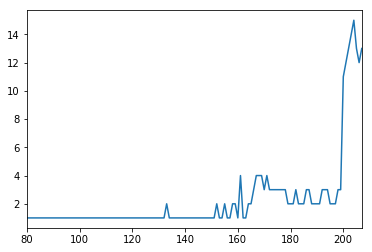

In [261]:
lendecis.plot()

In [262]:
lendecis[lendecis>1].iloc[:10]

133    2
152    2
155    2
158    2
159    2
161    4
164    2
165    2
166    3
167    4
dtype: int64

In [263]:
dfdecis2=dfdecis.copy()

In [264]:
dfdecis2.loc[133][1]=dfdecis2.loc[133][2]

In [265]:
def lftshftfll(x):
    y=x.copy().shift(-1)
    y.iloc[-1]=x.iloc[-1]
    return y

In [266]:
for j in np.arange(164,171+1):
    dfdecis2.loc[j]=lftshftfll(dfdecis2.loc[j])

In [267]:
dfdecis.loc[170][2]==dfdecis2.loc[170][1]

True

In [276]:
brk170=dfdecis2.loc[170][1].find('Votaram')

In [269]:
dfdecis2.loc[170][2]=dfdecis2.loc[170][1][brk170:]
dfdecis2.loc[170][1]=dfdecis2.loc[170][1][:brk170]

In [319]:
def delvote(x):
    y=x.copy()
    n=0
    while len(y.dropna())==len(x.dropna()):
        y=y.shift()
        n=n+1
    return y.shift(-n)

In [327]:
for j in np.arange(167,lstmeet+1):
    dfdecis2.loc[j]=delvote(dfdecis2.loc[j])

In [332]:
def tjn(x):
    y=x.copy().dropna().values
    return " ".join(y)

In [336]:
cptx=[tjn(dfdecis2.loc[j]) for j in meetlist2003all]

In [339]:
cptxlen=pd.Series([len(x) for x in cptx],index=meetlist2003all)

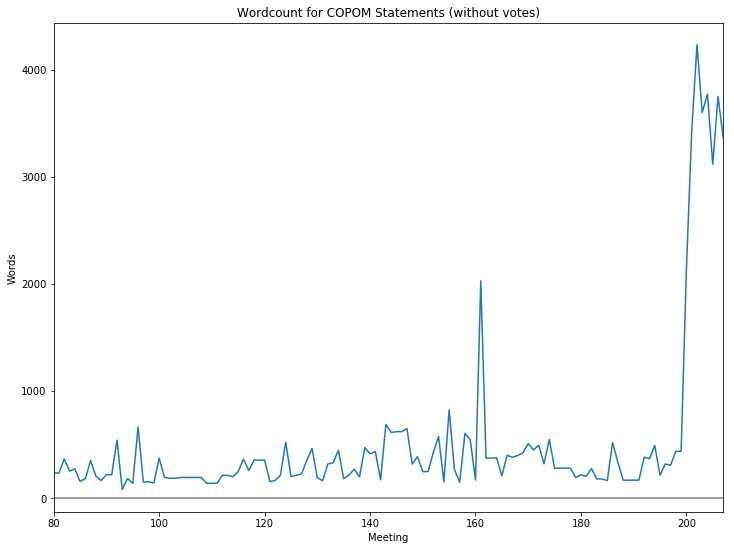

In [344]:
cptxlen.plot(figsize=(12,9),title='Wordcount for COPOM Statements (without votes)')
plt.axhline(0,color='gray')
plt.xlabel('Meeting')
plt.ylabel('Words')

In [341]:
dfdecis2.tail(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
198,"""O Copom decidiu, por unanimidade, manter a ta...",O Comitê reconhece os avanços na política de c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,"""O Copom decidiu, por unanimidade, manter a ta...",O Comitê reconhece os avanços na política de c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,"""O Copom decidiu, por unanimidade, manter a ta...",O cenário básico com que o Comitê trabalha pod...,O conjunto dos indicadores divulgados desde a ...,"No âmbito externo, o cenário permanece desafia...",As expectativas de inflação apuradas pela pesq...,As projeções condicionais do Copom para a infl...,O Comitê identifica os seguintes riscos domést...,"Por um lado, (i) a inflação acima do esperado ...","Por outro lado, (iv) os ajustes na economia po...","Tomados em conjunto, o cenário básico e o atua...",NaN,NaN,NaN,NaN,NaN
201,"""O Copom decidiu, por unanimidade, manter a ta...",O cenário básico com que o Comitê trabalha pod...,O conjunto dos indicadores divulgados desde a ...,"No âmbito externo, o cenário ainda apresenta i...","A inflação corrente segue pressionada, em part...",As expectativas de inflação apuradas pela pesq...,As projeções do Copom para a inflação de 2016 ...,O Comitê identifica os seguintes riscos domést...,"Por um lado, (i) a inflação acima do esperado ...","Por outro lado, (iv) índices de preços no atac...","Considerando o cenário básico, o balanço de ri...",NaN,NaN,NaN,NaN
202,"O Copom decidiu, por unanimidade, reduzir a ta...",O cenário básico do Copom pode ser resumido pe...,O conjunto dos indicadores divulgados desde a ...,"No âmbito externo, o cenário ainda apresenta i...",A inflação recente mostrou-se mais favorável q...,As expectativas de inflação apuradas pela pesq...,As projeções do Copom para a inflação de 2016 ...,O Comitê identifica os seguintes riscos domést...,"Por um lado, (i) o processo de aprovação e imp...","Por outro lado, (iv) a inflação mostrou-se mai...","Considerando o cenário básico, o balanço de ri...",A magnitude da flexibilização monetária e uma ...,NaN,NaN,NaN
203,"O Copom decidiu, por unanimidade, reduzir a ta...",A atualização do cenário básico do Copom pode ...,O conjunto dos indicadores divulgados desde a ...,"No âmbito externo, o cenário apresenta-se espe...",A inflação recente mostrou-se mais favorável q...,As expectativas de inflação apuradas pela pesq...,As projeções condicionais do Copom oscilaram e...,Os passos no processo de aprovação das reforma...,O Comitê ressalta os seguintes riscos para o c...,"Por um lado, (i) o possível fim do interregno ...","Por outro lado, (iv) a atividade econômica mai...","Considerando o cenário básico, o balanço de ri...",A magnitude da flexibilização monetária e a in...,NaN,NaN
204,"O Copom decidiu, por unanimidade, reduzir a ta...",A atualização do cenário básico do Copom pode ...,O conjunto dos indicadores sugere atividade ec...,"No âmbito externo, o cenário ainda é bastante ...",A inflação recente continuou mais favorável qu...,A inflação acumulada no ano passado alcançou 6...,As expectativas de inflação apuradas pela pesq...,As projeções condicionais do Copom também recu...,Os passos no processo de encaminhamento e apro...,O Comitê ressalta os seguintes riscos para o c...,"Por um lado, (i) o alto grau de incerteza no c...","Por outro lado, (iv) a atividade econômica mai...","Considerando o cenário básico, o balanço de ri...",O Copom avaliou a alternativa de reduzir a tax...,NaN
205,"O Copom decidiu, por unanimidade, reduzir a ta...",A atualização do cenário básico do Copom pode ...,O conjunto dos indicadores de atividade econôm...,"No âmbito externo, o cenário ainda é bastante ...",O comportamento da inflação permanece favoráve...,As expectativas de inflação apuradas pela pesq...,"No cenário de mercado, as projeções do Copom r...",O Comitê ressalta que seu cenário básico para ...,O Comitê destaca a importância da aprovação e ...,"Considerando o cenário básico, o balanço de ri...",